In [46]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-08-09 09:54:15,795: Credentials are already in use. The existing account in the session will be replaced.


In [47]:
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise


# and some tools 
import time
import matplotlib.pyplot as plt


In [48]:
# the simulator
sim = Aer.get_backend('aer_simulator')

In [49]:
def chsh_circuit(theta_vec):
    """Return a list of QuantumCircuits for use in a CHSH experiemnt
    (one for each value of theta in theta_vec)
    
        Args:
            theta_vec (list): list of values of angles between the bases of Alice and Bob
        
        Returns:
            List[QuantumCircuit]: CHSH QuantumCircuits for each value of theta
    """
    chsh_circuits = []
    
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11']
        for el in obs_vec:
            qc = QuantumCircuit(2,2)
            qc.h(0)
            qc.cx(0, 1)
            qc.ry(theta, 0)
            for a in range(2):
                if el[a] == '1':
                    qc.h(a) 
            qc.measure(range(2),range(2))
            chsh_circuits.append(qc)

    return chsh_circuits  

In [50]:
def compute_chsh_witness(counts):
    """Computes expectation values for the CHSH inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment
              (4 per value of theta)

        Returns:
            Tuple(List, List): Tuple of lists with the two CHSH witnesses
    """
    # Order is ZZ,ZX,XZ,XX
    
    CHSH1 = []
    CHSH2 = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):  
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chsh1 = 0
        chsh2 = 0

        for element in zz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zz[element]
            chsh2+= parity*zz[element]

        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zx[element]
            chsh2-= parity*zx[element]

        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1-= parity*xz[element]
            chsh2+= parity*xz[element]

        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xx[element]
            chsh2+= parity*xx[element]

        CHSH1.append(chsh1/no_shots)
        CHSH2.append(chsh2/no_shots)
    
    return CHSH1, CHSH2

In [51]:
number_of_thetas = 18
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
my_chsh_circuits = chsh_circuit(theta_vec)

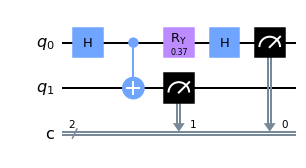

In [52]:
my_chsh_circuits[6].draw()

In [53]:
# Set devices, if using a real device
IBMQ.load_account()
# run on a quantum computer

from qiskit.providers.ibmq import least_busy

provider = IBMQ.load_account()

backend = least_busy(provider.backends(operational = True, simulator = False, status_msg='active',
                                      filters=lambda x: x.configuration().n_qubits >2))
print("we are executing on ...", backend)

#print(winning_probability(backend))
#provider = IBMQ.get_provider('ibm-q')
#quito = provider.get_backend(backend = backend)

ibmqfactory.load_account:WARNING:2021-08-09 09:54:20,422: Credentials are already in use. The existing account in the session will be replaced.
ibmqfactory.load_account:WARNING:2021-08-09 09:54:22,711: Credentials are already in use. The existing account in the session will be replaced.


we are executing on ... ibmq_belem


In [54]:
# Execute and get counts
result_ideal = sim.run(my_chsh_circuits).result()

tic = time.time()
transpiled_circuits = transpile(my_chsh_circuits, quito)
job_real = backend.run(transpiled_circuits, shots=8192)
job_monitor(job_real)
result_real = job_real.result()
toc = time.time()

print(toc-tic)

Job Status: job has successfully run
184.28710103034973


In [55]:
CHSH1_ideal, CHSH2_ideal = compute_chsh_witness(result_ideal.get_counts())
CHSH1_real, CHSH2_real = compute_chsh_witness(result_real.get_counts())

Text(0, 0.5, 'CHSH value')

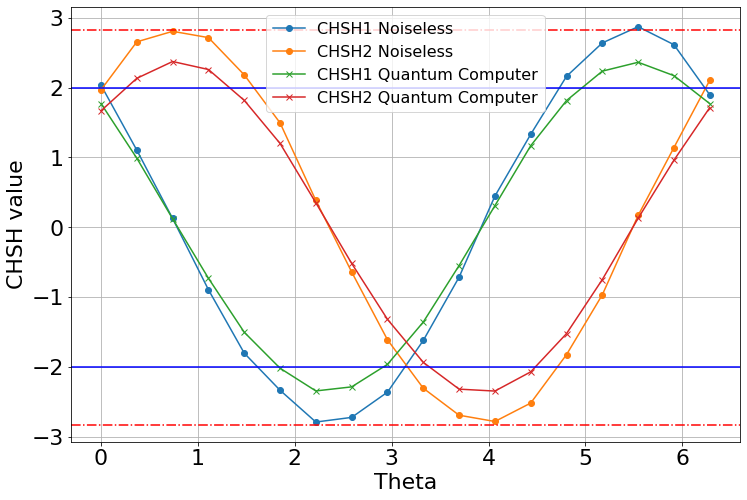

In [56]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(theta_vec,CHSH1_ideal,'o-',label = 'CHSH1 Noiseless')
plt.plot(theta_vec,CHSH2_ideal,'o-',label = 'CHSH2 Noiseless')

plt.plot(theta_vec,CHSH1_real,'x-',label = 'CHSH1 Quantum Computer')
plt.plot(theta_vec,CHSH2_real,'x-',label = 'CHSH2 Quantum Computer')

plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='b', linestyle='-')
plt.axhline(y=-2, color='b', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='r', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='r', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH value')